# **Entrega 3 - Ciencia de datos aplicada**
## **Reducción de accidentes viales en Bogotá**

### GSD+ & SDM Bogotá​

### **Integrantes**
*   Yachay J. Tolosa Bello – 202315750
*   Kevin Infante Hernández – 201117324​
*   John Vicente Moreno Triviño – 202210162

### **Objetivo**
*   Determinar los lugares y momentos prioritarios para llevar a cabo intervenciones enfocadas en reducir la siniestralidad y orientar el tipo de acciones a desplegar allí.

In [1]:
pip install -r ../requirements.txt > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import numpy as np
import shapely
import matplotlib.pyplot as plt
from holidays import country_holidays
from xgboost import XGBClassifier

from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
import joblib

Cargamos los datos de accidentes

In [3]:
accidentes_df = pd.read_csv("data/dataset_preparado.csv.gz", low_memory=False)

Cargamos la información geográfica de Bogotá y eliminamos la zona de Sumapaz

In [4]:
mapa_bogota = gpd.read_file("./data/bogota_cadastral.json")
mapa_bogota_no_sumapaz = mapa_bogota.cx[:, 4.45422 :]

In [5]:
def asignar_cuadrante(df, cols=13, rows=21):
    """
    Asigna a cada punto un cuadrante dada el tamaño de maya definida por cols y rows
    """
    
    bottomLeft = (4.45422, -74.22446)
    bottomRight = (4.45422, -73.99208494428275)
    topLeft = (4.833779672812246, -74.22446)
    topRight = (4.833779672812246, -73.99208494428275)
    
    cols = np.linspace(bottomLeft[1], bottomRight[1], num=cols + 1)
    rows = np.linspace(bottomLeft[0], topLeft[0], num=rows + 1)
    col = np.searchsorted(cols, df["X"]) - 1
    row = np.searchsorted(rows, df["Y"]) - 1
    df['cuadrante'] = row * (len(cols) - 1) + col
    df['col'] = row + 1
    df['row'] = col + 1

    cuadrantes_cord = []
    for i in range(len(rows) - 1):
        for j in range(len(cols) - 1):
            poly = shapely.geometry.box(cols[j], rows[i], cols[j + 1], rows[i + 1])
            cuadrantes_cord.append(poly)
    
    grid = gpd.GeoDataFrame(
        cuadrantes_cord, columns=["geometry"], crs=mapa_bogota_no_sumapaz.crs
    ).sjoin(mapa_bogota_no_sumapaz)[['geometry']].drop_duplicates()

    return df, grid



def enriquecer_fechas(df_base):

    df_base["hora"] = df_base.fecha_y_hora.dt.hour
    df_base["semana_del_año"] = df_base.fecha_y_hora.dt.isocalendar().week
    df_base["dia_de_la_semana"] = df_base.fecha_y_hora.dt.weekday
    df_base["mes"] = df_base.fecha_y_hora.dt.month
    
    colombian_holidays = country_holidays("CO")

    holidays = pd.DataFrame(
        index=pd.date_range(df_base.fecha_y_hora.min(), df_base.fecha_y_hora.max(), freq="d", normalize=True)
    )
    
    holidays["festivo"] = np.where(
        holidays.index.map(lambda x: x in colombian_holidays), 1, 0
    )
    
    df_base["fecha_truncada"] = df_base["fecha_y_hora"].dt.floor("d")
    
    df_base = df_base.join(holidays, on="fecha_truncada").drop(columns="fecha_truncada")

    return df_base
    

def crear_dataset(df, lapso="1h", cols=13, rows=21):
    """
    Crea un dataset de una grilla espacio temporal y marca cada cuadrante según el número de accidentes ocurridos
    """

    # Asignamos los cuadrantes
    df, grid = asignar_cuadrante(df, cols, rows)

    fecha_y_hora = pd.to_datetime(df["FECHA_OCURRENCIA_ACC"].str[:11] + df["HORA_OCURRENCIA_ACC"].str[:2])
    
    fechas = pd.DataFrame(
        pd.date_range( fecha_y_hora.min(), fecha_y_hora.max(), freq="1h"),
        columns=["fecha_y_hora"],
    )
    
    cuadrantes = df[["cuadrante", "row", "col"]].drop_duplicates()
    
    # Creamos una tabla del producto carteciano entre los cuadrantes y las fechas
    df_base = fechas.merge(cuadrantes, how="cross")

    # Agregamos el número de accidentes y marcamos en cero cuando no hay accidentes. 
    df_base = df_base.join(
        df.groupby([fecha_y_hora, "cuadrante"]).size().rename("n_accidentes"),
        on=["fecha_y_hora", "cuadrante"]
    ).fillna(0)
    
    # Re-muestreamos para tener los intervalos de tiempo del tamaño deseado
    result = df_base.groupby(["cuadrante", "col", "row", pd.Grouper(key="fecha_y_hora", freq=lapso)], as_index=False).sum()

    # # Agregamos las coordenadas promedio
    # result = result.join(
    #     df.groupby("cuadrante").agg(X=("X", "mean"), Y=("Y", "mean")),
    #     on="cuadrante",
    # )
    
    # creamos la variable accidentes indicando si hubo o no accidentes
    result["accidentes"] = np.where(result["n_accidentes"] > 1, 1, 0)

    result = enriquecer_fechas(result)

    # Trabajamos con datos resagados 7 para poder hacer predicciones 7 días adelante
    df_resagado = result.set_index(["fecha_y_hora"]).groupby("cuadrante").shift(7, freq="d")

    # Hubo accidentes hace n días a la misma hora:
    df_accidente_dias_resagados = pd.concat([
        df_resagado.groupby("cuadrante").shift(n, freq="d").set_index("cuadrante", append=True)["accidentes"].rename(f"accidente_{7 + n}_dias_antes_misma_hora")
        for n in range(30)
    ], axis=1).dropna()
    
    # Proporción de horas con accidentes en los últimos n días a la misma hora:
    df_accidente_dias_media_movil = pd.concat([
        df_accidente_dias_resagados[[f"accidente_{7 + n}_dias_antes_misma_hora" for n in range(n)]].mean(axis=1).fillna(0).rename(f"accidente_{7 + n}_dias_media_móvil")
        for n in [1, 7, 14, 21]
    ], axis=1)
    
    # Proporción de horas con accidentes en los últimos n días:
    df_horas_con_accidentes_resagado = pd.concat([
        df_resagado.groupby("cuadrante")["accidentes"].rolling(f"{n}d").mean().rename(f"accidentes_{7 + n}_media_móvil_día")
        for n in [1, 7, 14, 21]
    ], axis=1).reorder_levels(['fecha_y_hora', 'cuadrante'])

    df_caracteristicas = pd.concat([
        df_accidente_dias_resagados,
        df_accidente_dias_media_movil,
        df_horas_con_accidentes_resagado,
    ], axis=1).dropna()
    
    result = result.join(df_caracteristicas, on=['fecha_y_hora', 'cuadrante']).dropna()

    return result, grid



In [6]:
df, grid = crear_dataset(accidentes_df, lapso="4h", rows=6, cols=12)

In [7]:
X = df.drop(columns = ["accidentes", "n_accidentes", "fecha_y_hora"]) 
y = df["accidentes"]

In [8]:
fecha_corte_test_train = df["fecha_y_hora"] <= df["fecha_y_hora"].quantile(0.7)

X_train = X[fecha_corte_test_train]
X_test = X[~fecha_corte_test_train]

y_train = y[fecha_corte_test_train]
y_test = y[~fecha_corte_test_train]

<Axes: xlabel='accidentes'>

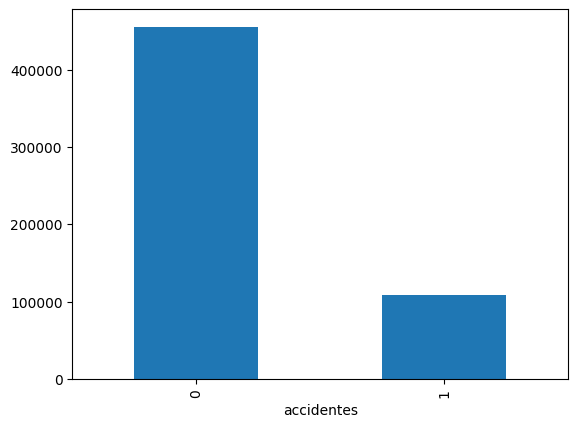

In [9]:
y_train.value_counts().plot.bar()

In [10]:
def sin_transform(x, period):
     return np.sin(x / period * 2 * np.pi)

def cos_transform(x, period):
     return np.cos(x / period * 2 * np.pi)

def sin_transformer(period):
    return FunctionTransformer(sin_transform, feature_names_out="one-to-one", kw_args=dict(period=period))

def cos_transformer(period):
    return FunctionTransformer(cos_transform, feature_names_out="one-to-one", kw_args=dict(period=period))


Para seleccioanar las características más relevantes se entrenó un modelo Random Forest. Se decisión utilizar esta técnica dado que muchas de las características contienen información similiar. 

In [11]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight="balanced"))
sel.fit(X_train, y_train)
características = list(X_train.columns[sel.get_support()])

# Características con importancia mayor que la media:
características

['cuadrante',
 'row',
 'hora',
 'semana_del_año',
 'dia_de_la_semana',
 'mes',
 'accidente_14_dias_media_móvil',
 'accidente_21_dias_media_móvil',
 'accidente_28_dias_media_móvil',
 'accidentes_8_media_móvil_día',
 'accidentes_14_media_móvil_día',
 'accidentes_21_media_móvil_día',
 'accidentes_28_media_móvil_día']

In [12]:
preproc = make_column_transformer(
    (sin_transformer(24), ["hora"]),
    (cos_transformer(24), ["hora"]),
    (sin_transformer(7), ["dia_de_la_semana"]),
    (cos_transformer(7), ["dia_de_la_semana"]),
    (sin_transformer(12), ["mes"]),
    (cos_transformer(12), ["mes"]),
    (sin_transformer(53), ["semana_del_año"]),
    (cos_transformer(53), ["semana_del_año"]),
    (
        StandardScaler(),
        [
             'cuadrante',
             'row',
             'accidente_14_dias_media_móvil',
             'accidente_21_dias_media_móvil',
             'accidente_28_dias_media_móvil',
             'accidentes_8_media_móvil_día',
             'accidentes_14_media_móvil_día',
             'accidentes_21_media_móvil_día',
             'accidentes_28_media_móvil_día'
        ]
    ),
)

## Regresión logística

In [13]:
from imblearn.over_sampling import SMOTE

lr_model = Pipeline([
   ("preprocesamiento", preproc),
   ("remuestreo", SMOTE()),
   ("modelo", LogisticRegression(class_weight="balanced")),
])

grid = [
    {
        "modelo__C": [0.1, 1, 10, 100],
        'remuestreo': ['passthrough', SMOTE(k_neighbors=5), SMOTE(k_neighbors=10), SMOTE(k_neighbors=20)],
        'modelo__penalty': ['l2'],
    },
    {
        "modelo__C": [0.1, 1, 10, 100],
        "modelo__l1_ratio": [0.1, 0.5, 1],
        'remuestreo': ['passthrough', SMOTE(k_neighbors=5), SMOTE(k_neighbors=10), SMOTE(k_neighbors=20)],
        'modelo__penalty': ['elasticnet'],
        'modelo__solver': ['saga'] # lbfgs no funciona con elasticnet
    }
]

lr_search = GridSearchCV(lr_model, grid, scoring="f1", cv=TimeSeriesSplit(), n_jobs=16)

lr_search.fit(X_train, y_train)

joblib.dump(lr_model, "lr_model.joblib")

pd.Series(lr_search.best_params_, name="valor").to_frame()

,valor
modelo__C,1
modelo__l1_ratio,0.1
modelo__penalty,elasticnet
modelo__solver,saga
remuestreo,SMOTE()


In [14]:
from sklearn.metrics import classification_report

y_pred_lr = lr_search.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85    199041
           1       0.42      0.72      0.53     42597

    accuracy                           0.77    241638
   macro avg       0.67      0.75      0.69    241638
weighted avg       0.84      0.77      0.79    241638



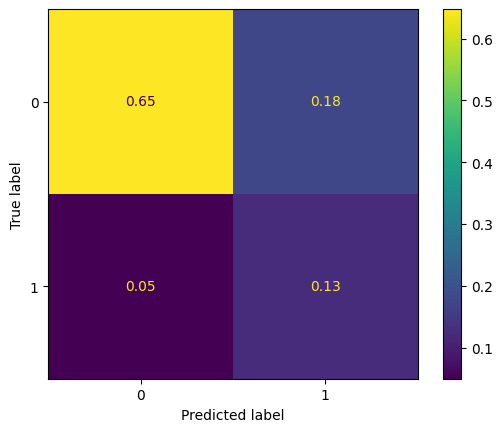

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_lr, normalize='all')).plot()

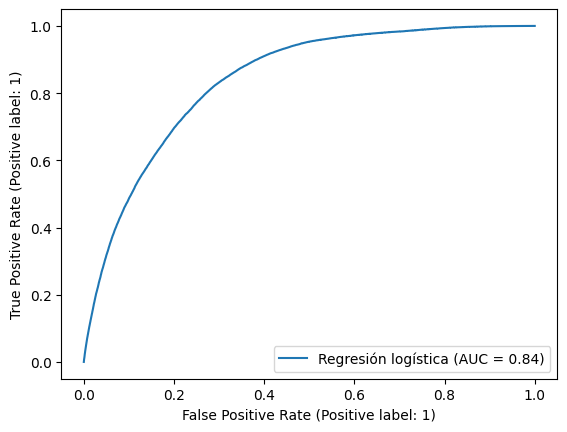

In [16]:
lr_roccurv = RocCurveDisplay.from_estimator(lr_search, X_test, y_test, name="Regresión logística")

## Random Forest

In [17]:
rf_model = Pipeline([
   ("preprocesamiento", preproc),
   ("remuestreo", SMOTE()),
   ("modelo", RandomForestClassifier(class_weight="balanced", n_jobs=10)),
])

grid = [
    {
        'remuestreo': ['passthrough', SMOTE(k_neighbors=5), SMOTE(k_neighbors=10)],
        'modelo__n_estimators': [100, 200],
        'modelo__max_depth': [1, 2, 4, 8]
    }
]

rf_search = GridSearchCV(rf_model, grid, scoring="f1", cv=TimeSeriesSplit(), n_jobs=8)

rf_search.fit(X_train, y_train)

joblib.dump(rf_search.best_estimator_ , "rf_model.joblib")

pd.Series(rf_search.best_params_, name="valor").to_frame()

/home/maini/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,valor
modelo__max_depth,8
modelo__n_estimators,200
remuestreo,SMOTE(k_neighbors=10)


In [18]:
y_pred_rf = rf_search.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84    199041
           1       0.41      0.77      0.53     42597

    accuracy                           0.76    241638
   macro avg       0.67      0.76      0.69    241638
weighted avg       0.84      0.76      0.79    241638



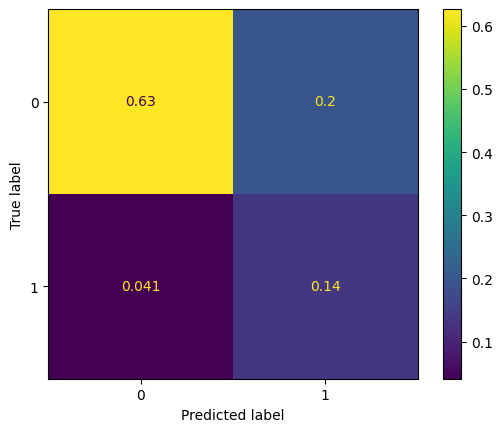

In [19]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf, normalize='all')).plot()

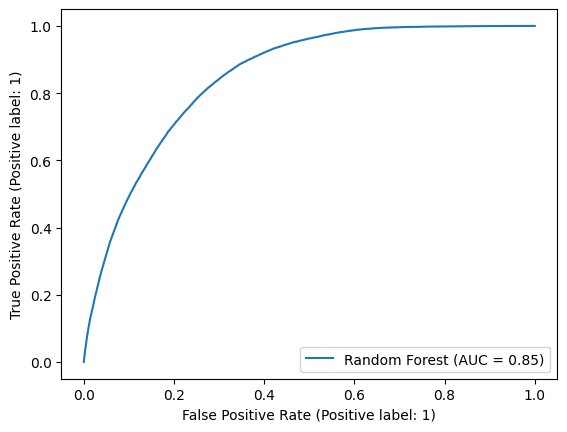

In [20]:
rf_roccurv = RocCurveDisplay.from_estimator(rf_search, X_test, y_test, name="Random Forest")

## XGBoost

In [21]:
xgb_model = Pipeline([
   ("preprocesamiento", preproc),
   ("remuestreo", SMOTE()),
   ("modelo", XGBClassifier()),
])

grid = [
    {
        'remuestreo': ['passthrough', SMOTE(k_neighbors=5), SMOTE(k_neighbors=10)],
        'modelo__n_estimators': [100, 200],
        'modelo__scale_pos_weight': [1, 2, 4],
        'modelo__tree_method': ['hist', 'approx'],
    }
]

xgb_search = GridSearchCV(xgb_model, grid, scoring="f1", cv=TimeSeriesSplit(), n_jobs=-1)

xgb_search.fit(X_train, y_train)

joblib.dump(xgb_search.best_estimator_ , "xgb_model.joblib")

pd.Series(xgb_search.best_params_, name="valor").to_frame()

,valor
modelo__n_estimators,100
modelo__scale_pos_weight,4
modelo__tree_method,approx
remuestreo,SMOTE()


In [22]:
joblib.dump(xgb_search.best_estimator_ , "xgb_model.joblib")

['xgb_model.joblib']

In [23]:
y_pred_xgb = xgb_search.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82    199041
           1       0.39      0.83      0.53     42597

    accuracy                           0.74    241638
   macro avg       0.67      0.77      0.67    241638
weighted avg       0.85      0.74      0.77    241638



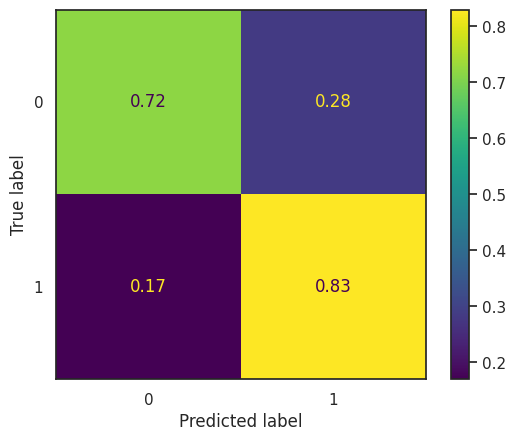

In [24]:
sns.set_theme("notebook", style="white", palette="muted")
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_xgb, normalize='true', )).plot()

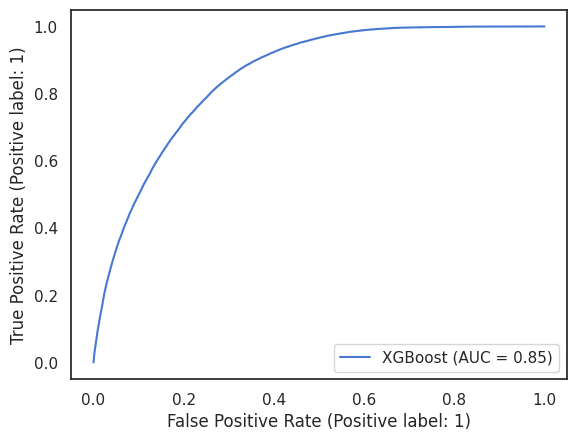

In [25]:
xgb_roccurv = RocCurveDisplay.from_estimator(xgb_search, X_test, y_test, name="XGBoost")

# Comparación de modelos

Text(0.5, 1.0, 'Comparación de la curva ROC de los tres modelos')

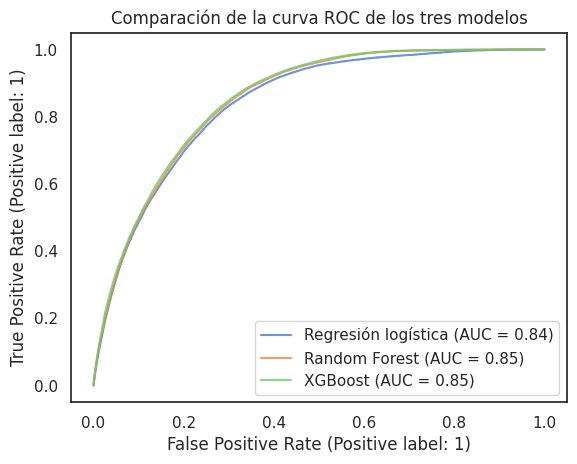

In [26]:
ax = plt.gca()

lr_roccurv.plot(ax=ax, alpha=0.8)
rf_roccurv.plot(ax=ax, alpha=0.8)
xgb_roccurv.plot(ax=ax, alpha=0.8)

plt.title("Comparación de la curva ROC de los tres modelos")

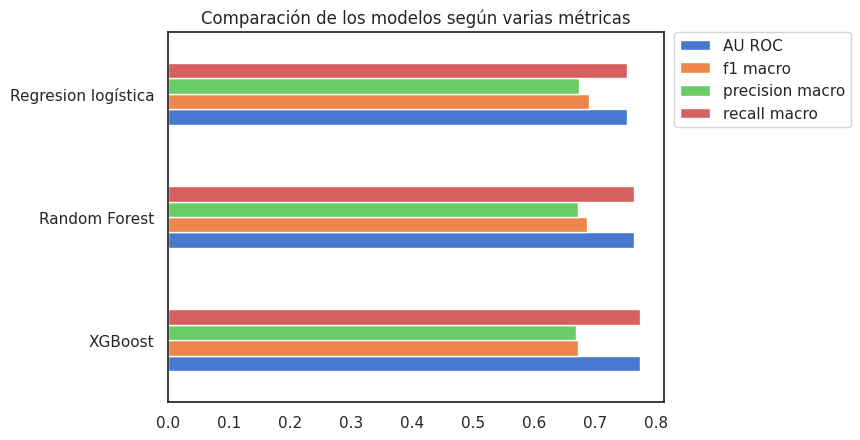

In [28]:
predicciones = {
    "Regresion logística": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
}

metricas = {
    "f1 macro": f1_score,
    "recall macro": recall_score,
    "precision macro": precision_score,
    "AU ROC": roc_auc_score,
}

ax = pd.Series(
    {(model, metrica): metric(y_test, pred, average="macro") for model, pred in predicciones.items() for metrica, metric in metricas.items()}
).unstack().sort_values("f1 macro").plot.barh(title="Comparación de los modelos según varias métricas")

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

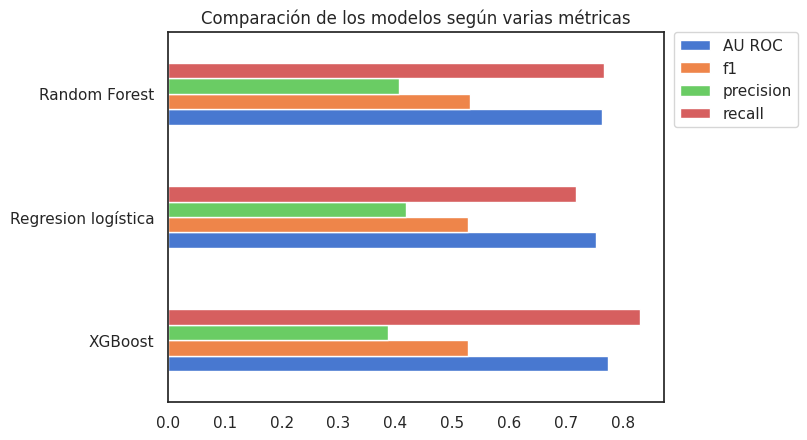

In [31]:
metricas = {
    "f1": f1_score,
    "recall": recall_score,
    "precision": precision_score,
    "AU ROC": roc_auc_score,
}

pd.Series(
    {(model, metrica): metric(y_test, pred) for model, pred in predicciones.items() for metrica, metric in metricas.items()}
).unstack().sort_values("f1").plot.barh(title="Comparación de los modelos según varias métricas")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<Axes: title={'center': 'Características utilizadas según su importancia en el modelo'}>

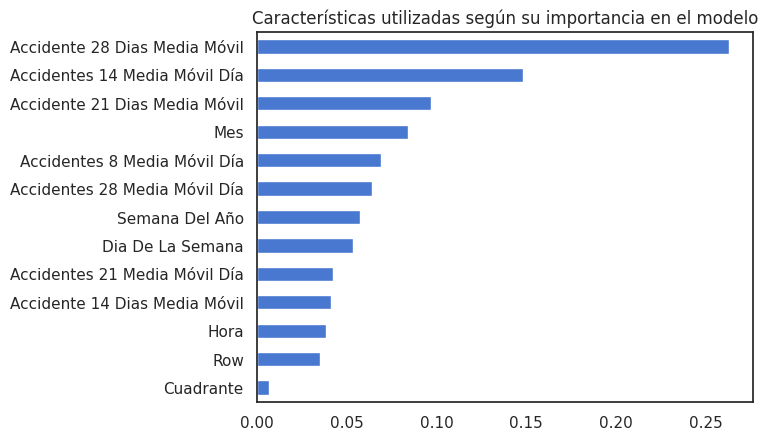

In [32]:
caracteristicas = pd.Series(
    xgb_search.best_estimator_[-1].feature_importances_,
    index=xgb_search.best_estimator_[:-1].get_feature_names_out()
)

caracteristicas.groupby(
    caracteristicas.index.map(lambda x: x.split("__")[-1].replace("_", " ").title())
).sum().sort_values().plot.barh(title="Características utilizadas según su importancia en el modelo")

## Umbral

In [33]:
probas = xgb_search.predict_proba(X_test)[:,1]

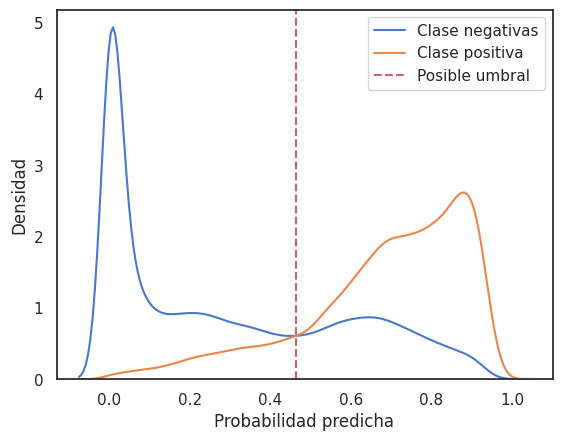

In [38]:
sns.kdeplot(probas[y_test==0], label="Clase negativas")
sns.kdeplot(probas[y_test==1], label="Clase positiva")

plt.xlabel("Probabilidad predicha")
plt.ylabel("Densidad")
plt.axvline(x=.463, color="r", linestyle="--", label="Posible umbral")
plt.legend()


              precision    recall  f1-score   support

           0       0.96      0.69      0.81    199041
           1       0.37      0.85      0.52     42597

    accuracy                           0.72    241638
   macro avg       0.67      0.77      0.66    241638
weighted avg       0.85      0.72      0.75    241638



Text(0, 0.5, 'Etiquetas verdaderas')

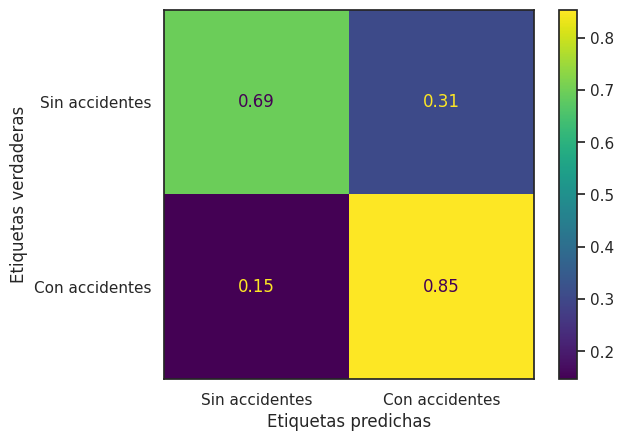

In [39]:
y_pred_xgb = np.where(xgb_search.predict_proba(X_test)[:,1] > 0.463, 1, 0)

print(classification_report(y_test, y_pred_xgb))

a = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_xgb, normalize='true', ), display_labels=["Sin accidentes", "Con accidentes"]).plot()

a.ax_.set_xlabel("Etiquetas predichas")
a.ax_.set_ylabel("Etiquetas verdaderas")

# Salidas

In [40]:
model = joblib.load("xgb_model.joblib")

In [41]:
df, grid = crear_dataset(accidentes_df, lapso="4h", rows=12, cols=6)
X = df.drop(columns = ["accidentes", "n_accidentes", "fecha_y_hora"]) 
y = df["accidentes"]
fecha_corte_test_train = df["fecha_y_hora"] <= df["fecha_y_hora"].quantile(0.7)

X_train = X[fecha_corte_test_train]
X_test = X[~fecha_corte_test_train]

y_train = y[fecha_corte_test_train]
y_test = y[~fecha_corte_test_train]

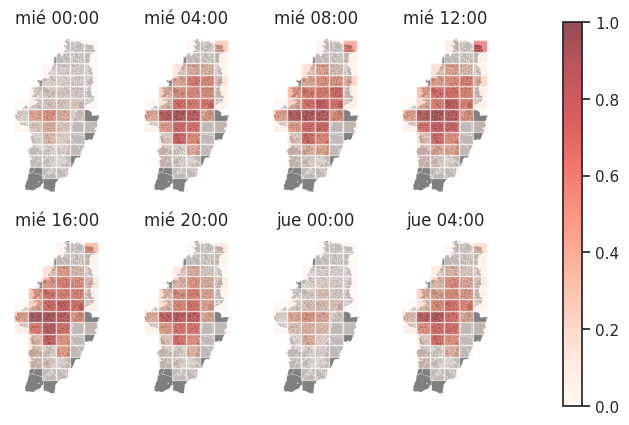

In [42]:
import locale
locale.setlocale(locale.LC_ALL, "es_CO.utf-8")


fig, axis = plt.subplots(2,4)
test_predictions = X_test.assign(proba=model.predict_proba(X_test)[:, 1])[["proba"]].join(df)
fechas = pd.Series(test_predictions['fecha_y_hora'].unique()[-8:])

for fecha, ax in zip(fechas, axis.flat):
    
    
    mapa_bogota_no_sumapaz.plot(ax=ax, alpha=1, fc="gray", ec="white", lw=0.1)
    grid.join(
        test_predictions[test_predictions['fecha_y_hora'] == fecha].set_index("cuadrante"),
        how="inner"
    ).plot(column="proba", ax=ax, alpha=0.5, vmin=0, vmax=1, cmap="Reds")
    ax.set_title(f"{fecha:%a %H:%M}")
    
    ax.axis("off")

sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=1))
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
fig.colorbar(sm, cax=cax, alpha=0.7)

# Entrenando modelos para diferentes tamaños de grilla

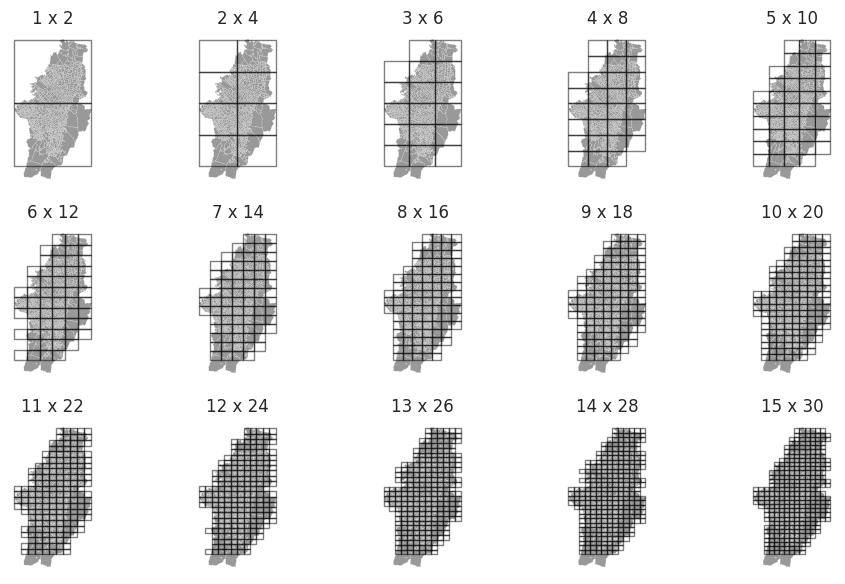

In [47]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6))

for cols, ax in enumerate(axes.flat):
    cols = cols + 1
    rows = 2 * cols
    df, grid = asignar_cuadrante(accidentes_df, cols=cols, rows=rows)
    mapa_bogota_no_sumapaz.plot(ax=ax, alpha=0.8, fc="gray", ec="white", lw=0.1)
    grid.plot(fc="none", ec="black", alpha=0.5, ax=ax)
    ax.set_title(f"{cols} x {rows}")
    ax.axis("off")
    
plt.tight_layout()

In [48]:
metricas = {
    "f1": f1_score,
    "recall": recall_score,
    "precision": precision_score,
    "auroc": precision_score,
}

results = {}

for cols in range(16):
    cols = cols + 1
    rows = 2 * cols
    
    df, grid = crear_dataset(accidentes_df, lapso="4h", rows=rows, cols=cols)
    X = df.drop(columns = ["accidentes", "n_accidentes", "fecha_y_hora"]) 
    y = df["accidentes"]
    fecha_corte_test_train = df["fecha_y_hora"] <= df["fecha_y_hora"].quantile(0.7)
    
    X_train = X[fecha_corte_test_train]
    X_test = X[~fecha_corte_test_train]
    
    y_train = y[fecha_corte_test_train]
    y_test = y[~fecha_corte_test_train]

    model.fit(X_train, y_train)

    joblib.dump(model, f"model_{cols}x{rows}.joblib")

    results[f'{cols}x{rows}'] = {metrica: metric(y_test, model.predict(X_test)) for metrica, metric in metricas.items()}


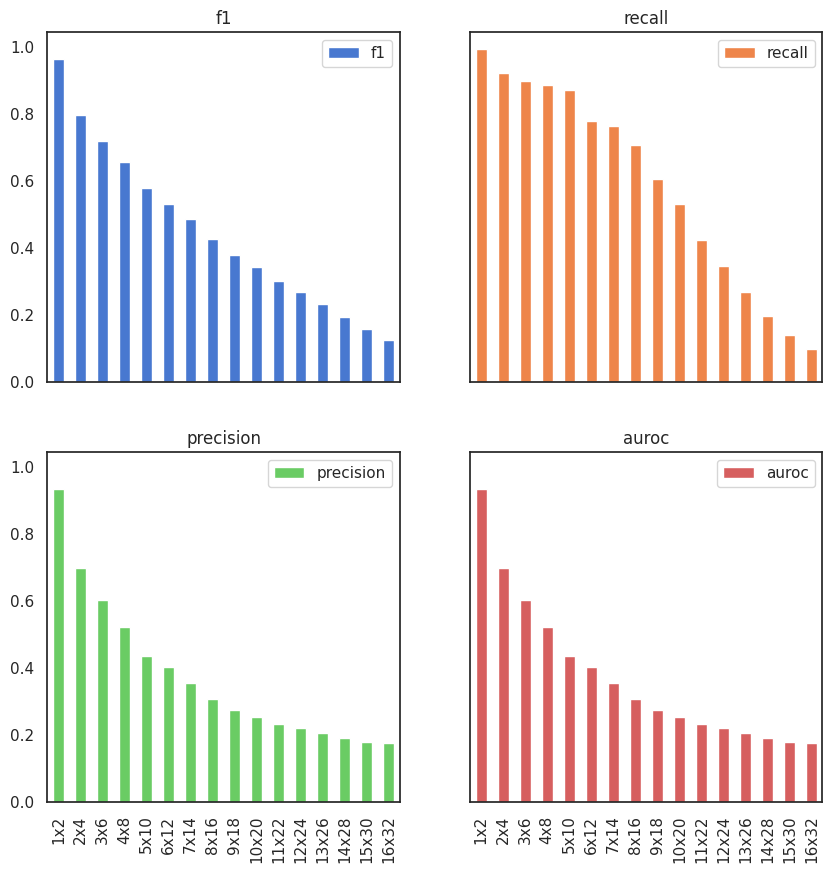

In [49]:
(
    pd.DataFrame(results).T
    .plot(subplots=True, layout=(2,2), sharex=True, sharey=True, kind="bar", figsize=(10,10))
);

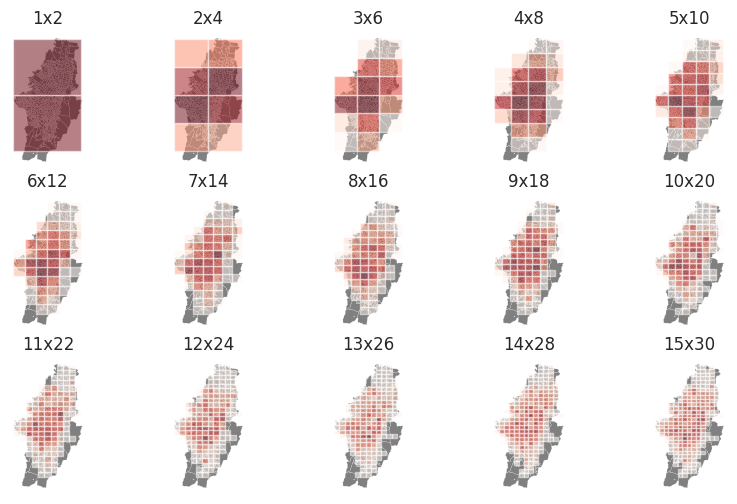

In [50]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6))

for cols, ax in enumerate(axes.flat):
    cols = cols + 1
    rows = 2 * cols
    
    df, grid = crear_dataset(accidentes_df, lapso="4h", rows=rows, cols=cols)
    
    X = df.drop(columns = ["accidentes", "n_accidentes", "fecha_y_hora"]) 
    y = df["accidentes"]
    fecha_corte_test_train = df["fecha_y_hora"] <= df["fecha_y_hora"].quantile(0.7)
    
    X_train = X[fecha_corte_test_train]
    X_test = X[~fecha_corte_test_train]
    
    y_train = y[fecha_corte_test_train]
    y_test = y[~fecha_corte_test_train]

    model = joblib.load(f"model_{cols}x{rows}.joblib")
    

    mapa_bogota_no_sumapaz.plot(ax=ax, alpha=1, fc="gray", ec="white", lw=0.1)

    test_data = df[df['fecha_y_hora'] == df["fecha_y_hora"].max()]
    test_predictions = test_data.assign(proba=model.predict_proba(test_data)[:, 1])
    
    grid.join(
        test_predictions.set_index("cuadrante"),
        how="inner"
    ).plot(column="proba", ax=ax, alpha=0.5, cmap="Reds", vmin=0) # , vmin=0, vmax=1
    ax.set_title(f"{cols}x{rows}")
    ax.axis("off")

# sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=1))
# cax = fig.add_axes([1, 0.1, 0.03, 0.8])
# fig.colorbar(sm, cax=cax, alpha=0.7)